## Table of Contents

- [Y5 Model Based Process Control](#Y5-Model-Based-Process-Control)
- [5.1 Motivation](#5.1-Motivation)
  - [5.2 Introduction to Model Based Process Control](#5.2-Introduction-to-Model-Based-Process-Control)
  - [5.3 Examples of Manufacturing Process Control](#5.3-Examples-of-Manufacturing-Process-Control)
  - [5.4 User Stories:](#5.4-User-Stories%3A)
- [🏠 Home](../../welcomePage.ipynb)

# Y5 Model Based Process Control

In [1]:
#install dependencies
import sys
!{sys.executable} -m pip install control

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 1.6 MB/s eta 0:00:00:00:01


In [2]:
#install dependencies
import sys
!{sys.executable} -m pip install control

# 5.1 Motivation
Like layers of an onion, production systems have multiple layers with different timescales relevant to each layer. In the production of a complex system of assebmlies of parts, such as a ground vehicle, the innermost layer is the workpiece layer at which each workpiece is shaped. Shaping processes include casting, forging, extrusion, forming, stamping, deposition, and machining. In fact, a combination of processes in sequence is often used to shape the workpiece to its final shape. At the workpiece layer of production, events at the millisecond time scale affect the quality and cost of production. Hence, sensor data should be collected at the millisecond time scale as well for process improvement.
<center>
    <img src="../../img/Process Layers of Production Technology Fig 11.1.svg" alt="The layers of production are shown as concentric rings with the workpiece at the center and the assembly of workpieces as the next ring out from the center." width="600">
</center>
The next layer outside of the workpiece layer is the assembly layer in which workpieces are joined into an assembly. The timescale of events and their data relevance is typically larger at this layer, for example, a timescale of minutes, although precise millisecond data my be releveant during brief events of joining and fastening. This module will not cover the larger layers of the complete system/product and its usage in the field with their associated longer event and data timescales.

With these layers of production in mind, we turn to the task of using data collected at the millisecond-to-minute time scale to improve the processes of workpiece shaping and assembly joining, realizing that digitally actuated machine tools can run more optimally simply by making digital changes (modified software, modified parameter files) in an improvement cycle that far exceeds the rate of learning of a human operator, for example, a welder executing a repetitive manual operation. For automated production processes, we can construct "gray box" models for direct digital control of a process using combinations of technical information and raw data from the production process. Furthermore, this approach can provide useful information to humans for the critical tasks of process planning, production management, and production development.

Our schematic for this modle based process control is shown below. We will see how a single machine on a shop floor can participate in the optimization of model based process control, and then how the data and experiences of one machine can enable improvements across all the machines performing this process within a network or "World Wide Lab" of connected shop floors.

<center>
    <img src="../../img/Model Based Control System for Manufacturing Process.svg" alt="This schematic of a model based control system for a manufacturing process shows a typical closed loop control system diagram with a sensed output signal fed back to control. Important additions are the collection of data from the Decision & Control block as well as the Machine block. Furthermore, the control section of the diagram is broken into a sequence of three blocks: Model Identification, Model Optimization, and Decision & Control" width="800">
</center>

## 5.2 Introduction to Model Based Process Control

Objective:  Understand how process data can be collected and used to improve performance.
(Introduction to process data collection methods, such as sensors.)

### 5.2.1 Sensing and Data Aggregation
Machine tools typically have integrated sensors in their design and often have the ability to acquire and transmit data from these onboard sensors. For example, a CNC (computer numerically controlled) machining center typically has sensing through linear or rotary position encoders on its motion stages, a spindle speed sensor, and sensors on the amount of electric current applied to each motor (a signal proportional to force in linear motion or torque in rotary motion). The process data on the motor drive's internal microcontroller registers can also be collected such as the tool number of the active tool, the present line number of the NC program, the zero point offset, and the sensed position and commanded position and their difference (the position error). Similarly, velocity and acceleration errors can be collected as well. More advanced machines may also include thermal, acoustic, and vibrational sensing and machine vision, or aftermarket sensor packages can be added to a machine to collect this as well. All of this data may be collected as fast as the position control cycle (1000 Hz gives a 1 millisecond sampling interval). One challenge, however, is the lack of an industry-wide standard for the sensor data interface and data format. Middleware software providers offer solutions to collect the data using the available interface of the machine tool with an additional computer.

Data standards are as follows. Low-frequency dimensional data may be captured using the standardized OPC UA (Open Platform Communications Unified Architecture) interface for a machine.
Once read, the machine data can be sent through a network using a publish/subscribe protocol such as MQTT (Message Queuing Telemetry Transport). The midddleware annotates machine information with metadata for automatic structuring and storage in a database.

In addition to these integrated sensors on the machine tool, sensing is available in stanadard metrology and quality inspection steps which involve transporting the workpiece from the machine tool to a metrology lab. While metrology data collected according to ISO standards on a coordinate measuring machine is both accurate and precise, the time and inconvenience of moving the workpiece to a climate controlled lab and waiting for the workpiece to reach the standard specified temperature are good reasons to seek faster measurement options. CNC machines have probing systems which can give on-machine workpiece geometry measurements. These on-machine measurements will have higher error than CMM measurements due to both thermal expansion and geometric errors of the CNC machine tool.se

### 5.2.2 Definition of Process Control

We use process control to manage and maintain the quality, efficiency, and consistency of manufacturing processes. 
The goal is to ensure that products are produced within specification, while minimizing variability and defects, and maximizing throughput or otherwise reducing cost of production.

Process control has two main approaches:
1. **Statistical Process Control**: In this approach, a typically well-controlled process can be monitored for deviation and adjustments made to bring the process back within control limits. As its name implies, statistical models are used to mathematically describe the process from measured process data. It is these statistical models that enable the decision-making of selecting the best course of action to bring the process to the desired state.
2. **Dynamic System Control**: Alternatively, this approach uses the mathematics of differential equations and dynamic systems to describe system behavior in order to control system behavior.
Dynamic systems are those for which the state or status of the system changes in time according to some mathematical rule.
Typically, the output can be predicted from the input, with some level of uncertainty, by applying the known mathmatical rules, called the system model.
System models employ differential equations in which the time derivative (the rate-of-change) of a state variable is a known function of that state variable and the other state variables and inputs of the system.

Some examples of dynamic control are:
- **PID Controllers**: Pronounced "P. I. D.", these controllers use an error signal and its integral and derivative to generate an input actuation to the process under control. Typically they are tuned once and set for implementation to drive the output to a new or changing setpoint during the process.
- **Model-based Optimal Controllers**: Typically linear dynamical system models are used to describe the behavior of a system at operating levels near the desired operation point. These models have some error as physical processes often have significant nonlinearity. The benefit of using linear models is that optimization theory has already been developed, giving controllers which can drive a linear system to the desired state under some optimization such as minimum time or minimum energy expenditure. An optimal controller can exceed the performance of a PID controller when a well-identified linear model is used to compose the optimal controller, essentially because the optimal controller has more levers for tuning its performance.
- **Model-based Robust Controllers**: When the process under control exhibits variations such as disturbances due to additional physical inputs, a controller can lose performance. For example, a process which varies with ambient temperature will suffer if it uses the same PID controller or model-based optimal controller despite significant variation in ambient temperature. Essentially the variation represents an aspect of the process that is not captured in the linear model that was used to tune the optimal controller. One approach to handle expected variations is to model the amount of variation in the process behavior. With the combination of a linear model and its uncertainty, an optimal controller can be constructed to optmize for its performance across a range of operating conditions. The end result is a tuned controller which work can work well enough over a range of operating conditions. We call this robust as the controller tuning is robust to a specified level of variations, noise, or disturbance.
- **Model Predictive Controllers**: The variations in a process due to uncontrolled inputs or changes in the states can be modeled. If such a model is constructed and has low error, it can be used in this advanced form of control. The model predictive controller will use a computer simulation of a short term horizon of the behavior of the system. With this simulation, the controller will solve an optimization problem to determine the best sequence of actuations to drive the output to the desired state within the time horizon. Once that optimization is solved, the next actuation value is taken from the solution to the optimization problem and used as the actuation of the physcial process. This process of prediction and optimizaiton for actuation is repeted at each timestep. This controller works well even for somewhat nonlinear processes. The cost of so much comptuation is the requirement for a capable microprocessor embedded close to the system, which can be well worth the expense.
 
The key to both the statistical and dynamic system approaches is a mathematical model, and both approaches benefit from statistical analysis of uncertainty. We will explore further the models used in process control in order to understand their limits and how big data is enabling better performance than ever in model based process control.

In Dynamic System Control, a control system can be mathematically formulated in order to optimize system performance.
The control system can be simulated with a system model to validate its performance in a computer simulation.
Later, the control system can be tested with a mixture of hardware and computer simulations in a procedure called "hardware-in-the-loop" (HIL) testing.
The physical hardware can include control electronics, actuators, and sensors. The computer models can simulate parts of the manufacturing system which are more expensive to prototype, have challenging safety concerns, or have a longer lead time.
The benefit of HIL testing is to further validate the control system implementation, now admitting effects that were not captured in the earlier simulations without hardware. These effects include the conversions between analog signals and digital signals, time delays, and physical interactions such as electromagnetic interference.
HIL testing is still less expensive than full scale testing which requires the investment in the process and feedstock materials and produces waste when the process outputs are not in the specified tolerance. 

## 5.3 Examples of Manufacturing Process Control


### 5.3.1 Example Model and Sensor for Robot End-of-Arm Effector
Let's consider the case of a gripper at the end of an industrial robot arm, like the image below.
<center>
    <img src="../../img/Module5_RobotExtruder.jpeg" alt="An industrial robot arm with end of arm tool gripper mechanism." width="60%">
</center>

Consider a gripper design with integrated gearmotor (electrical torque actuator) and potentiometer (angle sensor).

A classical linear control system can be constructed to drive the angle of the gripper to a desired position in time.
This is a feedback control system approach using the joint angle feedback signal from the potentiometer.
Because DC motors, gearboxes, and potentiometers are standard components with well-established dynamical models, we can construct a first-prinicples model of this system in order to design a controller.

We can neglecting the electrical dynamics due to the motor's self-inductance because they are much faster than the mechanical dynamics of the moving robot joint link.
We construct a first-order model of the gearmotor from the motor's supplied voltage $V_\text{supply}(t)$ in units of volts to the anglar speed of the motor shaft $\omega_m(t)$ in units of radians per second.
$$ J \frac{d}{dt}\omega_m(t) + \left( b + \frac{K_m^2}{R} \right) \omega_m(t) = \frac{K_m}{R} V_\text{supply}(t) $$
Notice that the previous equation gives a first-order linear ordinary differential equation with input signal $V_\text{supply}(t)$ and output signal $\omega_m(t)$, which is why we call it a first-order dynamic system model. 
The highest power of $\frac{d}{dt}$ in the equation is the first power, hence first order.

Note that in a gearmotor, a gearbox connects the motor shaft to the load shaft, and so there are transformations in speed and torque across this gearbox from intput to output shaft.
For this reason, we include a $\frac{1}{N}$ factor to reduce the motor shaft speed by the gearbox's speed reduction ratio $N$ in order to get the speed of the robot joint connected to the gearbox output shaft.
$$\omega_\text{output}(t) = \frac{1}{N} \omega_m(t)$$
Further, to get the robot joint angle, we need to apply an integral to the speed signal with respect to time.
$$\theta_\text{output}(t) = \int \omega_\text{output}(t) \, dt$$

Lastly, the sensor we use is a potentiometer.
We model this as a simple gain between the physical variable $\omega_\text{output}(t)$ and the voltage it generates in volts.
$$V_\text{sensed} = K_p \omega_\text{output}(t)$$

We can construct the following block diagram of the closed loop angular control system.
<div hidden>
    TK: update the block diagram with Kp outside like Fig. 28.4, and replace K_T and K_b with K_m replacing K_b and K_T = K_m/R
    TK: include a diagram of the specific motor and gearbox and joint and show the angles.
</div>
<center>
    <img src="../../img/Block Diagram Robot Arm.png" alt="A block diagram of the robot gripper final linkage with gearmotor and potentiometer sensor." width="400">
</center>

The block with gain $K$ is the controller. This block amplifies one voltage signal to create another voltage signal. The voltage going into block $K$ is a voltage proportional to the error in angular position.
$$V_\text{error}(t) = K_p \left( \theta_\text{desired}(t)-\theta_\text{output}(t) \right) $$

$$V_\text{supply}(t) = K V_\text{error}(t)$$

We now need to create an equation using our model in order to design control gain $K$ to achieve some system performance objective.

Objective: Zero position overshoot.
This objective is important when handing brittle materials such as ceramics. If the robot gripper closes its grip with a position overshoot of the gripper into the material, it can strain the material and cause fracture.

Analysis of the block diagram gives a simplifed closed loop block with the following gain:
$$\frac{K_p K K_m }{R N s\left(Js+b+\frac{K_m^2}{R} \right) + K_p K K_m}$$ 

This can be re-written:
$$\frac{K_p K K_m }{\left(JRN s^2+(b+\frac{K_m^2}{R})RNs \right) + K_p K K_m}$$

And again as:
$$\frac{ \frac{K_p K K_m }{JRN}}{s^2+\left(\frac{b}{J}+\frac{K_m^2}{RJ}\right)s + \frac{K_p K K_m }{J R N}}$$


We can equate the denominator with the characteristic polynominal equation of a second-order system parameterized by damping ratio $\zeta$ and natural frequency $\omega_n$.

$$ s^2+\left(\frac{b}{J}+\frac{K_m^2}{RJ}\right)s + \frac{K_p K K_m }{J R N}= \left(s^2 + 2\zeta\omega_n s + \omega_n^2\right)$$

We see that $\omega_n$ can be determined independently of $\zeta$ in the equation above, but the value of the controller gain $K$ affects $\omega_n$.
$$\omega_n = \sqrt{\frac{K_p K K_m }{J R N}}$$

The damping ratio $\zeta$ also follows from $K$ in the equation.
$$\zeta = \frac{ \frac{b}{J}+\frac{K_m^2}{RJ} }{ 2 \sqrt{\frac{K_p K K_m }{J R N}}}$$

We can sovle this equation for $K$ and simplify as follows:
$$ K = \frac{ \left(\frac{b}{J}+\frac{K_m^2}{RJ}\right)^2 }{ 4 \frac{\zeta^2 K_p K_m }{J R N}}$$

The question remains: what value to set for $K$ (the controller gain), as the natural frequency and damping ratio of the system depends on $K$?

Zeta ($\zeta$) determines the amount of overshoot, and $\omega_n$ does not determine the degree of overshoot.
It is well known property of second-order systems that there will be no overshoot to a step input signal for $\zeta=1$. However, engineers commonly tolerate some overshoot as long as there is no ringing (no oscillation of the output. There is no ringing for $\zeta \ge \frac{\sqrt{2}}{2} \approx 0.707$.
For this reason, engineering systems are often tuned to have $\zeta = \approx 0.7$.

Our system model lets us design the controller gain $K$ and plot expected system responses to specified input signals.

Let's plot this, starting with $K=0.707$.


In [4]:
#set model parameters
K_p = 5.7 #volts per radian
K_m = 0.25 #motor constant in newton-meters per ampere, which is equivalent to back emf constant in volt-seconds per radian
R = 1.25 #ohms
J = 1.75e-5 #newton meter-seconds-squared per radian
b = 2.0e-5 # newton-meter-seconds per radian
N = 1000 #gear speed reduction ratio of gearmotor
print('K_p = ',K_p,'volts per radian')
print('K_m = ',K_m,'newton-meters per ampere, equivalent to volts-seconds/radian')
print('R = ',R,'ohms')
print('J = ',J,'newton meter-seconds-squared per radian')
print('b = ',b,'newton meter-seconds per radian')
print('N = ',N)
print('model parameters are loaded')

K_p =  5.7 volts per radian
K_m =  0.25 newton-meters per ampere, equivalent to volts-seconds/radian
R =  1.25 ohms
J =  1.75e-05 newton meter-seconds-squared per radian
b =  2e-05 newton meter-seconds per radian
N =  1000
model parameters are loaded


In [5]:
#Set damping ratio to see performance
from ipywidgets import interact,interactive,widgets
from IPython.display import display

zeta = 0.707
# text_widget = widgets.Text(description="Variable:")
zetaSlider = widgets.FloatSlider(
    value=zeta,
    min=0,
    max=1.0,
    step=0.001,
    description="Zeta (ζ):",
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)


def update_variable(change):
    global zeta
    zeta = change.new
    # print(f"Variable updated to: {my_variable}")

zetaSlider.observe(update_variable, names='value')
display(zetaSlider)



# Example of changing the variable
# text_widget.value = "Hello"
# Output: Variable updated to: Hello

FloatSlider(value=0.707, description='Zeta (ζ):', max=1.0, readout_format='.3f', step=0.001)

damping ratio ζ = 0.279
For this ζ, the designed controller gain is: K = 402787.6 volts per volt
And the natural frequency ω_n = 5122.4 radians per second
In hertz, the natural frequency is f_n = 815.3 hertz


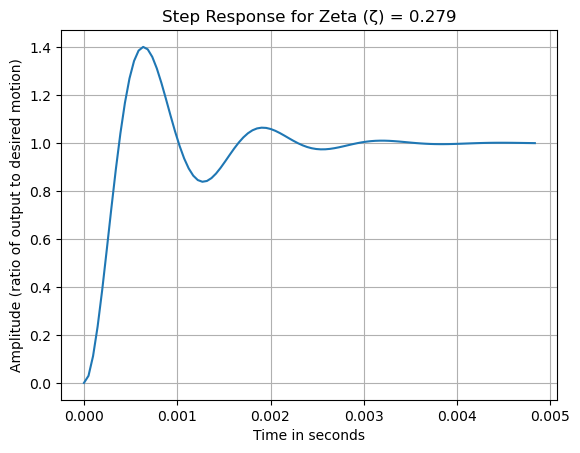

In [8]:
#calculate system properties
import math
print(f"damping ratio ζ = {zetaSlider.value:0.3f}")
K = (b/J+K_m**2/R/J)**2/(4*zetaSlider.value**2*K_p*K_m / (J*R*N))
print(f"For this ζ, the designed controller gain is: K = {K:0.1f} volts per volt");
omega_n = math.sqrt(K_p*K*K_m / (J*R*N) )
print(f"And the natural frequency ω_n = {omega_n:0.1f} radians per second")
print(f"In hertz, the natural frequency is f_n = {omega_n/2/math.pi:0.1f} hertz")
#plot the step response from the transfer function

    
import numpy as np
import matplotlib.pyplot as plt
import control

# Define the transfer function
num = [K_p*K*K_m/J/R/N]  # Numerator coefficients
den = [1, b/J+K_m**2/J/R, K_p*K*K_m/J/R/N]  # Denominator coefficients

# alternative calculation for a second order system:
# num = omega_n**2
# den = [1, 2*zetaSlider.value*omega_n, omega_n**2]

tf = control.TransferFunction(num, den)

# Calculate the step response
t, y = control.step_response(tf)

# Plot the step response
plt.plot(t, y)
plt.xlabel("Time in seconds")
plt.ylabel("Amplitude (ratio of output to desired motion)")
plt.title(f"Step Response for Zeta (ζ) = {zetaSlider.value:0.3f}")
plt.grid(True)
plt.show()

What have we learned?
We saw that an engineering system can be controlled with feedback control. A potentiometer sensor was used as a feedback sensor on the joint angle of a robot arm. The actuator and sensor system was analyzed mathematically in order to design a closed loop control system. The control system was tuned (the controller gain $K$ set to a value) and the system performance predicted using a mathematical model. This model-based control system allows the designer to see the expected performance of the system.
As you adjust zeta ($\zeta$) you will see that the step response has a higher peak for lower values of $\zeta$. For example, a $\zeta \approx 0.63$ gives a peak amplitude of 1.1 in the step response. This means 10% overshoot to position. That could be enough to break a fragile component being gripped by the robot arm. A smart design for handling fragile components is a large $\zeta \approx 1$.

A manufacturing process example will be selected with an accurate nonlinear, noisy model of the process.
A process setpoint will be selected.
Designed controllers of a few types will be demonstrated: PID, Optimal, Robust, and MPC.
The error signal will be plotted.
The area under the error signal curve will be shaded and a bar chart plotted.
The controller with the least error will be identified.

The plots will be repeated for a different setpoint with the controller.
This should show the robust controller outperforming the optimal controller.
The model predictive controller should have good performance in each case. 

Remaining Outline:

-  See a variety of controllers drive error to zero
-  	See noise/disturbance/model uncertainty-  •	See data used to identify/fit/train a mode-  
-	True process will have time dependent degradation (mass, damping, etc) plus temp dependent behavior (time since startup, 1st order response, 70 minute time constant), plus temp depdented behavior to environment temp (trapezoidal wave for HVAC system) plus random noise
-	Train using data from day 1 or machie  1
-	Train using a dayslys  ta
-	Train using last 1 hour data, evaluate controller performa

Use example of a robotic gripper
Frequency domain controller - designed with specifications.
Alternative - add a sensor ( a potentiometer with DAQ), use full state feedback control - get better performance.
explore the sensor and DAQ setup, concepts of resolution, sample rate, performance hits for these.nce

Remaining Outline:

-  See a variety of controllers drive error to zero-  	See noise/disturbance/model uncertainty-  •	See data used to identify/fit/train a mode-  
-	True process will have time dependent degradation (mass, damping, etc) plus temp dependent behavior (time since startup, 1st order response, 70 minute time constant), plus temp depdented behavior to environment temp (trapezoidal wave for HVAC system) plus random noise-•	Train using data from day 1 or machie  1-
•	Train using a dayslys  t-
•	Train using last 1 hour data, evaluate controller performa

Use example of a robotic gripper
Frequency domain controller - designed with specifications.
Alternative - add a sensor ( a potentiometer with DAQ), use full state feedback control - get better performance.
explore the sensor and DAQ setup, concepts of resolution, sample rate, performance hits for these.ce


## 5.4 User Stories:
- [Model Predictive Control](../../Modules/Examples/2.%20Learning%20Modules/2.6.%20Model%20Predictive%20Control/Model%20Predictive%20Control.ipynb) - This module demonstrates calculating a single time step's move trajectory using the same system as the Dahlin controller.

### <center>[◀︎ Module 4](Module4.ipynb)     [🏠 Home](../../welcomePage.ipynb)     [Module 6 ▶︎](Module6.ipynb)</center>